In [130]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy import sin 
from numpy import cos
from math import acos
from math import atan
from math import radians
from math import sqrt

class Vehicle:
    def __init__(self, v = 500, x = 0, z = 0, y = 0, theta = 0, phi = 0):
        self.position = []
        self.v = v
        self.theta = theta
        self.phi = phi
        self.x = x
        self.z = z
        self.y = y
        self.r = sqrt(self.x**2 + self.z**2 + self.y**2)
        self.dx = self.dz = self.dy = 0
        self.position.append([self.x, self.z, self.y])
    
    def update(self, dv, dtheta, dphi, dt):
        self.v += dv
        self.r = self.v * dt
        self.theta += dtheta
        self.phi += dphi
        self.dx = self.r * cos(self.theta) * cos(self.phi)
        self.dz = self.r * cos(self.theta) * sin(self.phi)
        self.dy = self.r * sin(self.theta)   
        self.x += self.dx #if abs(self.dx) > (0.0001 * dt) else 0
        self.z += self.dz #if abs(self.dz) > (0.0001 * dt) else 0
        self.y += self.dy #if abs(self.dy) > (0.0001 * dt) else 0
        self.position.append([self.x, self.z, self.y])
    
##########################################################################################################

class Simulation:
    def __init__(self, D0, epsilon0, sigma0, VT, VM, dt, tf, theta_t, phi_t, theta_m, phi_m):
        self.D0 = D0
        self.epsilon0 = epsilon0
        self.sigma0 = sigma0
        self.VT = VT
        self.VM = VM
        self.dt = dt
        self.tf = tf
        self.theta_t = theta_t
        self.phi_t = phi_t
        self.theta_m = theta_m
        self.phi_m = phi_m
    
    def simulation(self, G = 2, S = 1, manuver_target = True):
        def vectorInit():
            def epsilon0_sigma0():
                AB = np.array(target.position) - np.array(missile.position)
                AB = AB[0]
                BC = np.array(target.position) - np.array(missile.position)
                BC[0][2] = 0
                BC = BC[0]
                CD = np.array(target.position) - np.array(missile.position)
                CD[0][1] = CD[0][2] = 0
                CD = CD[0]
                AB_mg = np.linalg.norm(AB)
                BC_mg = np.linalg.norm(BC)
                CD_mg = np.linalg.norm(CD)
                ABdotBC = np.dot(AB,BC)
                BCdotCD = np.dot(BC,CD)
                epsilon0 = acos(ABdotBC / (AB_mg * BC_mg))
                sigma0 = acos(BCdotCD / (CD_mg * BC_mg))
                return epsilon0, sigma0
            time = np.arange(0, self.tf, self.dt)
            D       = [None] * len(time)
            epsilon = [None] * len(time)
            thetam = [None] * len(time)
            Jn_theta = [None] * len(time)
            Jn_phi = [None] * len(time)
            
            thetam[0] = 0
            sigma   = [None] * len(time)
            D[0] = target.r - missile.r
            epsilon[0], sigma[0] = epsilon0_sigma0()
            return D, epsilon, sigma, thetam, time
        
        def targetMove(manuver_target = True):
            if manuver_target == True:
                maxdef = 8 * self.dt
                dtheta_t = radians(random.uniform(-maxdef, maxdef))
                dphi_t = radians(random.uniform(-maxdef, maxdef))
                target.update(0, dtheta_t, dphi_t, self.dt)
            else:
                dtheta_t = 0
                dphi_t = 0
                target.update(0, dtheta_t, dphi_t, self.dt)
                
        def Solver():
            def RungeKutta(f, y0):
                k1 = f(t0, y0)
                k2 = f(t0 + 0.5 * self.dt, y0 + 0.5 * k1)
                k3 = f(t0 + 0.5 * self.dt, y0 + 0.5 * k2)
                k4 = f(t0 + self.dt, y0 + k3)
                y = (k1 + k2 + k2 + k3 + k3 + k4) / 6
                return y
            
            def Euler(f, y0):
                return f(t0, y0)
            
            def D_dotf(t, D):
                delta_D = target.v * cos(sigma0-target.phi) * cos(epsilon0-target.theta) - missile.v * cos(sigma0-missile.phi) * cos(epsilon0-missile.theta)
                return delta_D
            
            def epsilon_dotf(t, epsilon_0):
                delta_epsilon = (missile.v * cos(sigma0-missile.phi) * sin(epsilon_0-missile.theta) - target.v * cos(sigma0-target.phi) * sin(epsilon_0-target.theta))/D0
                return delta_epsilon
            
            def sigma_dotf(t, sigma_0):
                delta_sigma = (missile.v * sin(sigma_0-missile.phi) * cos(missile.theta) - target.v * sin(sigma_0-target.phi) * cos(target.theta))/(D0*cos(epsilon0))
                return delta_sigma
            
            if solver == "Euler":
                D_d = Euler(D_dotf, D0)
                epsilon_d = Euler(epsilon_dotf, epsilon0)
                sigma_d = Euler(sigma_dotf, sigma0)
            elif solver == "Runge kutta":
                D_d = RungeKutta(D_dotf, D0)
                epsilon_d = RungeKutta(epsilon_dotf, epsilon0)
                sigma_d = RungeKutta(sigma_dotf, sigma0)
            return D_d, epsilon_d, sigma_d
        
        def updateObservation():
            epsilon[i] = epsilon[i-1] + epsilon_d * self.dt
            sigma[i] = sigma[i-1] + sigma_d * self.dt
            D[i] = D[i-1] + D_d * self.dt
            
        def IdealBond():
            thetaM_old = missile.theta
            phiM_old = missile.phi
            # Missile gives new commands
            if Guidance_Law == "Pure pursuit":
                thetaM_new = epsilon[i]
                phiM_new = sigma[i]
            elif Guidance_Law == "Deviated pursuit":
                epsilon_p = 5
                sigma_p = 5
                epsilon_p = radians(epsilon_p)
                sigma_p = radians(sigma_p)
                thetaM_new = epsilon[i] - epsilon_p
                phiM_new = sigma[i] - sigma_p
            elif Guidance_Law == "Porportional navigation":
                k1 = 5
                k2 = 5
                thetaM_new = thetaM_old + k1 * epsilon_d * self.dt
                phiM_new = phiM_old + k2 * sigma_d * self.dt
            dtheta_m = thetaM_new - thetaM_old
            dphi_m = phiM_new - phiM_old
            return dtheta_m, dphi_m
        
        def PlotTrajectories(target_position, missile_position, view = "3D", title = "Figure"):
            xt, zt, yt = zip(*target_position)
            xm, zm, ym = zip(*missile_position)
            if view == "3D":
                fig = plt.figure(figsize=(8, 8))
                fig.suptitle(title, fontsize=20)
                ax = Axes3D(fig)
                #ax.set_xlim3d(-5000, 80000)
                #ax.set_ylim3d(-5000, 80000)
                #ax.set_zlim3d(-5000, 80000)
                ax.set_xlabel('X axis', fontsize=16)
                ax.set_zlabel('Y axis', fontsize=16)
                ax.set_ylabel('Z axis', fontsize=16)

                ax.plot(xt, zt, yt, label='Target Trajectory')
                ax.plot(xm, zm, ym, label='Missile Trajectory')
                ax.scatter(xt[-1], zt[-1], yt[-1], c='r', marker='x')   # End point
                ax.scatter(xt[0], zt[0], yt[0], c='k', marker='*')   # Start point
                ax.scatter(xm[-1], zm[-1], ym[-1], c='r', marker='o')   # End point
                ax.scatter(xm[0], zm[0], ym[0], c='g', marker='s')   # Start point
                ax.legend()
                plt.grid()
                plt.show()
            elif view == "XY" or view == "YX":
                fig = plt.figure(figsize=(8, 8))
                fig.suptitle(title, fontsize=20)
                plt.xlabel('X axis', fontsize=16)
                plt.ylabel('Y axis', fontsize=16)
                plt.plot(xt, yt, label='Target Trajectory')
                plt.plot(xm, ym, label='Missile Trajectory')
                plt.scatter(xt[-1], yt[-1], c='r', marker='x')   # End point
                plt.scatter(xt[0], yt[0], c='k', marker='*')   # Start point
                plt.scatter(xm[-1], ym[-1], c='r', marker='o')   # End point
                plt.scatter(xm[0], ym[0], c='g', marker='s')   # Start point
                plt.legend()
                plt.grid()
                plt.show()
            elif view == "ZY" or view == "YZ":
                fig = plt.figure(figsize=(8, 8))
                fig.suptitle(title, fontsize=20)
                plt.xlabel('Z axis', fontsize=16)
                plt.ylabel('Y axis', fontsize=16)
                plt.plot(zt, yt, label='Target Trajectory')
                plt.plot(zm, ym, label='Missile Trajectory')
                plt.scatter(zt[-1], yt[-1], c='r', marker='x')   # End point
                plt.scatter(zt[0], yt[0], c='k', marker='*')   # Start point
                plt.scatter(zm[-1], ym[-1], c='r', marker='o')   # End point
                plt.scatter(zm[0], ym[0], c='g', marker='s')   # Start point
                plt.legend()
                plt.grid()
                plt.show()
            elif view == "XZ" or view == "ZX":
                fig = plt.figure(figsize=(8, 8))
                fig.suptitle(title, fontsize=20)
                plt.xlabel('X axis', fontsize=16)
                plt.ylabel('Z axis', fontsize=16)
                plt.plot(zt, xt, label='Target Trajectory')
                plt.plot(zm, xm, label='Missile Trajectory')
                plt.scatter(zt[-1], xt[-1], c='r', marker='x')   # End point
                plt.scatter(zt[0], xt[0], c='k', marker='*')   # Start point
                plt.scatter(zm[-1], xm[-1], c='r', marker='o')   # End point
                plt.scatter(zm[0], xm[0], c='g', marker='s')   # Start point
                plt.legend()
                plt.grid()
                plt.show()
            
        xt = self.D0 * cos(radians(self.epsilon0))*cos(radians(self.sigma0))
        zt = self.D0 * cos(radians(self.epsilon0))*sin(radians(self.sigma0))
        yt = self.D0 * sin(radians(self.epsilon0))
        target = Vehicle(v = self.VT, x = xt, z = zt, y = yt, theta = radians(self.theta_t), phi = radians(self.phi_t))
        missile = Vehicle(v = self.VM, x = 0, z = 0, y = 0, theta = radians(self.theta_m), phi = radians(self.phi_m))       
        Guidance_Laws = ["Pure pursuit", "Deviated pursuit", "Porportional navigation"]
        Guidance_Law = Guidance_Laws[G]       
        Solvers = ["Euler", "Runge kutta"]
        solver = Solvers[S]
        D, epsilon, sigma, thetam, time = vectorInit()
        missile.theta = epsilon[0]
        missflag = 0
        
        for i in range(1, len(time)):
            t0 = time[i-1]
            t1 = time[i]
            D0 = D[i-1]
            epsilon0 = epsilon[i-1]
            sigma0 = sigma[i-1] 
            targetMove(manuver_target)
            D_d, epsilon_d, sigma_d = Solver()
            updateObservation()
            
            if abs(D[i]) < 50:
                timeHit = time[i]
                print("Missile hit the target using ", Guidance_Law," after ", timeHit," seconds")
                break
            elif D[i] > D[i-1]:
                missflag = missflag + 1
                if missflag == 2:
                    print("Missile missed the target")
                    break
                else:
                    missflag = 0
            
            dtheta_m, dphi_m = IdealBond()
            missile.update(0, dtheta_m, dphi_m, self.dt)
            thetam[i] = missile.theta
            
        PlotTrajectories(target.position, missile.position, "3D", "3D Trajectory")
        return target.position, missile.position, timeHit

In [131]:
One = Simulation(D0 = 37000, epsilon0 = 35, sigma0 = 0, VT = 200, VM = 800, dt = 0.1, tf = 1000, theta_t = 0, phi_t = 0, theta_m = 0, phi_m = 0)

Missile hit the target using  Porportional navigation  after  57.400000000000006  seconds


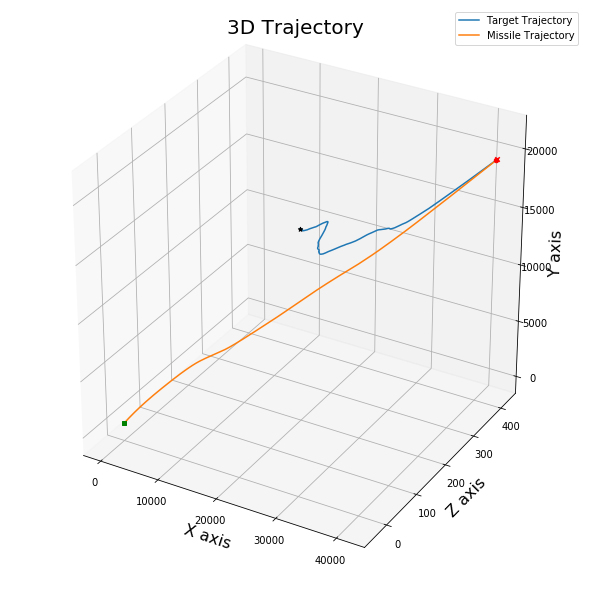

In [139]:
x, y , t= One.simulation(G = 2, S = 0, manuver_target = True)